In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [2]:
data = pd.read_csv("data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = y_test.reshape(-1,1)

In [3]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8820, 34)
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
def displayStats(model,modelname: str,test: np.ndarray,truth: np.ndarray):
    predictions = model.predict(test) #all of them should have this
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,predictions)))

   #not all models have predict_proba
    if callable(getattr(model, "predict_proba", None)):
        soft_predictions = model.predict_proba(test)[:,1]
        print("ROC AUC: "+str(roc_auc_score(truth,soft_predictions)))
    
    cmat = confusion_matrix(truth,predictions)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Catboost Classifier - Attempt 2
---
## Issues with the first attempt
---
We found that our first attempt varied (in accuracy) greatly between different random test sets. This could indicate overfitting portions of the data. This could be due to a relatively small dataset size, which leads to the classifier not being able to really learn the correct things. 

---
## Improvement ideas
---
First, we will try to see if performance goes up if we try to train a "good frame" vs "bad frame" binary classifier, instead of a "good clip" vs "bad clip" binary classifier. The idea is that this will significantly increase the size of the dataset that we have available to us, helping the classifier generalize a bit more. 

If this yields improved results, we will then try to extend this concept of "good frames" vs "bad frames" by trying to create a basic composite score for each clip based on its proportion of good frames and bad frames. We can output this both as a soft score (the exact percentage of good vs bad) and as a hard score (if more good frames, we predict good clip, if more bad frames, we predict bad clip).

---
### Frame by Frame Classifier
---

In [5]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train,y_train)

Learning rate set to 0.022413
0:	learn: 0.6898247	total: 55.2ms	remaining: 55.1s
1:	learn: 0.6863428	total: 59.9ms	remaining: 29.9s
2:	learn: 0.6823599	total: 63.8ms	remaining: 21.2s
3:	learn: 0.6787770	total: 69.4ms	remaining: 17.3s
4:	learn: 0.6750546	total: 73.7ms	remaining: 14.7s
5:	learn: 0.6711662	total: 77.8ms	remaining: 12.9s
6:	learn: 0.6680393	total: 83ms	remaining: 11.8s
7:	learn: 0.6647386	total: 87.8ms	remaining: 10.9s
8:	learn: 0.6613540	total: 92.4ms	remaining: 10.2s
9:	learn: 0.6578799	total: 98.2ms	remaining: 9.72s
10:	learn: 0.6548622	total: 103ms	remaining: 9.24s
11:	learn: 0.6520608	total: 107ms	remaining: 8.83s
12:	learn: 0.6495958	total: 111ms	remaining: 8.46s
13:	learn: 0.6468803	total: 117ms	remaining: 8.27s
14:	learn: 0.6442497	total: 122ms	remaining: 8s
15:	learn: 0.6420207	total: 126ms	remaining: 7.75s
16:	learn: 0.6395773	total: 132ms	remaining: 7.64s
17:	learn: 0.6374353	total: 137ms	remaining: 7.47s
18:	learn: 0.6353801	total: 141ms	remaining: 7.28s
19:	le

CATBOOST REV 2 STATS:
ACCURACY: 0.8994708994708994
ROC AUC: 0.9659957719746729


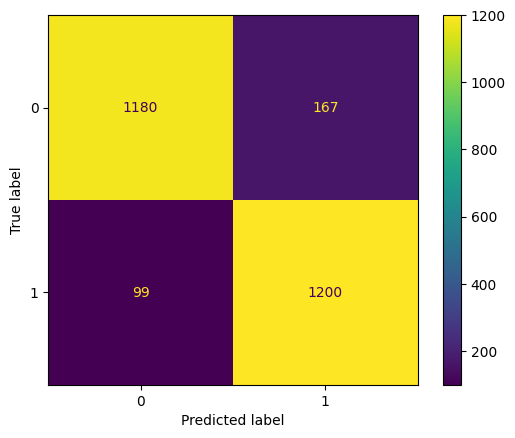

In [6]:
displayStats(cbm, "CATBOOST REV 2", X_test, y_test)

### Sanity Check

---

Let's generate a histogram of multiple CBTrees on different splits, and their respective statistics

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(100):
    data = pd.read_csv("data_nonconcat.csv",header=None)
    data = data.sample(frac=1)
    data = data.reset_index(drop=True)
    labels = data[0]
    data = data.drop(0,axis='columns')
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.asarray(y_train.values.tolist())
    y_train = y_train.reshape(-1,1)
    y_test = np.asarray(y_test.values.tolist())
    y_test = y_test.reshape(-1,1)

    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train,y_train)

    predictions = cbm.predict(X_test) #all of them should have this
    print("ACCURACY: "+str(accuracy_score(y_test,predictions)))
    acc = accuracy_score(y_test,predictions)
    accuracies.append(acc)

print(accuracies)

### Conclusions of Frame by Frame classifier

---
The frame by frame classifier seems to do pretty well on random frames. We can now try to extend this concept to classifying on each clip. 

---


## Clip by Clip Classifier

---

1. Import the concatenated vector data so that we have an entire clip as a row

In [15]:
data_C = pd.read_csv("data_concat.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

In [16]:
print(pd.Series(labels_C).value_counts())
print(pd.Series(y_train_C.ravel()).value_counts())
print(pd.Series(y_test_C.ravel()).value_counts())

0.0    74
1.0    73
Name: 0, dtype: int64
1.0    52
0.0    50
dtype: int64
0.0    24
1.0    21
dtype: int64


In [17]:
print("NONCONCAT DATA SHAPES")
# print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("CONCAT DATA SHAPES")
# print(data_C.shape)
print(X_train_C.shape)
print(X_test_C.shape)
print(y_train_C.shape)
print(y_test_C.shape)

NONCONCAT DATA SHAPES
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)
CONCAT DATA SHAPES
(102, 2040)
(45, 2040)
(102, 1)
(45, 1)


2. Reshape to extract frame-by-frame 

In [18]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_Cr.shape)
print(X_test_Cr.shape)


CONCAT DATA SHAPES AFTER RESHAPING
(6120, 34)
(2700, 34)


3. Stretch the y-labels of training and test set to fit the reshaped arrays

In [22]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_Cr = np.copy(y_train_C)
y_test_Cr = np.copy(y_test_C)

y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
y_train_Cr = np.reshape(y_train_Cr,(-1,1))
y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
y_test_Cr = np.reshape(y_test_Cr,(-1,1))

print("LABEL SHAPES AFTER STRETCHING")
print(y_train_Cr.shape)
print(y_test_Cr.shape)

LABEL SHAPES BEFORE STRETCHING
(102, 1)
(45, 1)
LABEL SHAPES AFTER STRETCHING
(6120, 1)
(2700, 1)


In [23]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train_Cr,y_train_Cr)

Learning rate set to 0.022329
0:	learn: 0.6879087	total: 4.46ms	remaining: 4.46s
1:	learn: 0.6829741	total: 9.01ms	remaining: 4.5s
2:	learn: 0.6774432	total: 12.6ms	remaining: 4.17s
3:	learn: 0.6731264	total: 16.1ms	remaining: 4.02s
4:	learn: 0.6684336	total: 19.7ms	remaining: 3.93s
5:	learn: 0.6640168	total: 23.5ms	remaining: 3.89s
6:	learn: 0.6594718	total: 27.3ms	remaining: 3.87s
7:	learn: 0.6550167	total: 31ms	remaining: 3.85s
8:	learn: 0.6505730	total: 35ms	remaining: 3.85s
9:	learn: 0.6471165	total: 39.2ms	remaining: 3.88s
10:	learn: 0.6430748	total: 42.9ms	remaining: 3.86s
11:	learn: 0.6393524	total: 46.5ms	remaining: 3.83s
12:	learn: 0.6354313	total: 50ms	remaining: 3.79s
13:	learn: 0.6321001	total: 54ms	remaining: 3.81s
14:	learn: 0.6282839	total: 58.4ms	remaining: 3.83s
15:	learn: 0.6250365	total: 62.2ms	remaining: 3.82s
16:	learn: 0.6223594	total: 66.8ms	remaining: 3.86s
17:	learn: 0.6193036	total: 71.7ms	remaining: 3.91s
18:	learn: 0.6160276	total: 75.4ms	remaining: 3.89s
1

4) Check the frame by frame accuracy of the fit classifier

CATBOOST REV 2 STATS:
ACCURACY: 0.6662962962962963
ROC AUC: 0.734348544973545


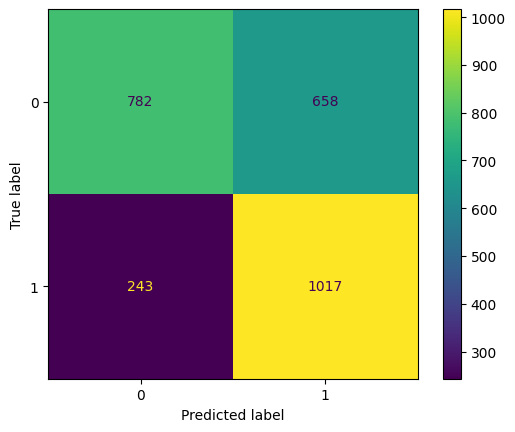

In [24]:
displayStats(cbm, "CATBOOST REV 2", X_test_Cr, y_test_Cr)

The frame by frame accuracy is worse, due to the less shuffled nature of the training dataset (we're shuffling in 60-frame chunks, instead of single frame shuffling)

Let's attempt to use this classifier to vote on clips, but if this does not work well, we may need to explore alternative strategies.

5) Classify 60 frames at a time (one clip) and take a majority consensus to classify a clip.

In [64]:
preds = []
softpreds = []
for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
    clip = np.reshape(clip,(1,-1))
    numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
    numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
    clip = np.reshape(clip,(numrows, numcols))
    
    #classify each row in clip
    clipPreds = cbm.predict(clip)
    clipSoftPreds = cbm.predict_proba(clip)[:,1]
    softprediction = np.average(clipSoftPreds)
    
    prediction = np.sum(clipPreds)
    if(prediction < (clipPreds.shape[0]/2)):
        prediction = 0
    else:
        prediction = 1
    
    preds.append(prediction)
    softpreds.append(softprediction)
preds = np.asarray(preds)
softpreds = np.asarray(softpreds)

ACCURACY: 0.6888888888888889
ROC AUC: 0.8194444444444444


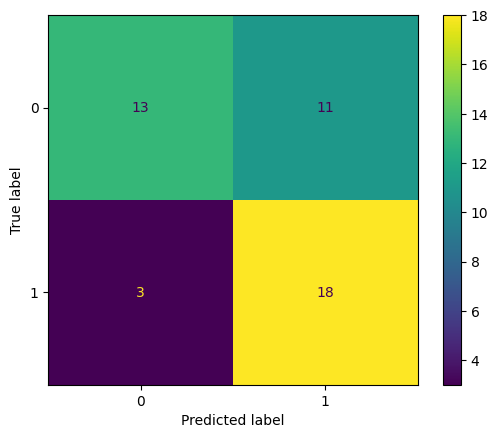

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

preds = np.reshape(preds,(-1,1))
print("ACCURACY: "+str(accuracy_score(y_test_C,preds)))
print("ROC AUC: "+str(roc_auc_score(y_test_C,softpreds)))

cmat = confusion_matrix(y_test_C,preds)
disp = ConfusionMatrixDisplay(cmat)
disp.plot()
plt.show()

The accuracy does not drop off significantly compared to classifying individual frames in the random frame classification. One possible hyperparameter that we can tune to improve it is the bias when computing the voted score. Currently, bad frames and good frames contribute equally to the clip's prediction. However, we can adjust this to bias more towards good frames, or more towards bad frames, and see if we can boost the accuracy. 

First however, we need to generate a histogram to look at accuracy across multiple runs.

## Sanity Check
Generating histogram for clip classifier

---

In [70]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot

accuracies = []
roc_aucs = []

for i in range(100):
    #get the data
    data_C = pd.read_csv("data_concat.csv",header=None)
    data_C = data_C.sample(frac=1)
    data_C = data_C.reset_index(drop=True)
    labels_C = data_C[0]
    data_C = data_C.drop(0,axis='columns')
    X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
    X_train_C = X_train_C.to_numpy()
    X_test_C = X_test_C.to_numpy()
    y_train_C = np.asarray(y_train_C.values.tolist())
    y_train_C = y_train_C.reshape(-1,1)
    y_test_C = np.asarray(y_test_C.values.tolist())
    y_test_C = y_test_C.reshape(-1,1)

    #transform
    newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
    X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

    newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
    X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

    y_train_Cr = np.copy(y_train_C)
    y_test_Cr = np.copy(y_test_C)

    y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
    y_train_Cr = np.reshape(y_train_Cr,(-1,1))
    y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
    y_test_Cr = np.reshape(y_test_Cr,(-1,1))

    # fit classifier
    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train_Cr,y_train_Cr)
    preds = []
    softpreds = []
    for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
        clip = np.reshape(clip,(1,-1))
        numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
        numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
        clip = np.reshape(clip,(numrows, numcols))
        
        #classify each row in clip
        clipPreds = cbm.predict(clip)
        clipSoftPreds = cbm.predict_proba(clip)[:,1]
        softprediction = np.average(clipSoftPreds)
        
        prediction = np.sum(clipPreds)
        if(prediction < (clipPreds.shape[0]/2)):
            prediction = 0
        else:
            prediction = 1
        
        preds.append(prediction)
        softpreds.append(softprediction)
    preds = np.asarray(preds)
    softpreds = np.asarray(softpreds)
    preds = np.reshape(preds,(-1,1))
    
    accuracies.append(accuracy_score(y_test_C,preds))
    roc_aucs.append(roc_auc_score(y_test_C,softpreds))

<Figure size 640x480 with 0 Axes>

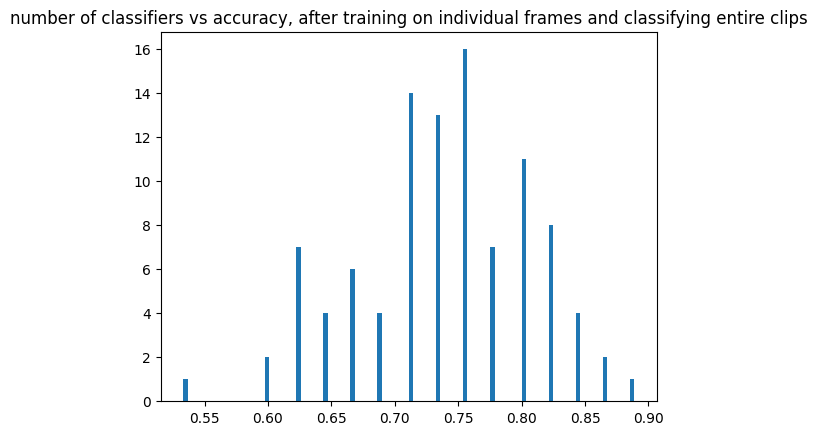

<Figure size 640x480 with 0 Axes>

In [72]:
plt.hist(accuracies,bins=100)
# acchistnp = np.histogram(accuracies,bins=100)
# print("std deviation: "+str(np.std(acchistnp)))
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

In [76]:
accuracies = np.asarray(accuracies)
print("STD Deviation of accuracy: "+str(np.std(accuracies)))
print("mean of accuracy: "+str(np.mean(accuracies)))

STD Deviation of accuracy: 0.06896626478947765
mean of accuracy: 0.7382222222222222


In [79]:
roc_aucs = np.asarray(roc_aucs)
print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs)))
print("mean of ROC-AUC: "+str(np.mean(roc_aucs)))

STD Deviation of ROC-AUC: 0.07080735041496872
mean of ROC-AUC: 0.7970710496837978


### Conclusion of Clip Classifier using frame classification

---

We can see that the accuracy has improved over the raw clip classification, and that the standard deviation of that accuracy itself has gone down. This makes sense, as the classifier has much more data to train on, and can better. By classifying the frames of each clip and taking a majority vote of good frames vs bad frames, it also softens the impact of minor deviations, whereas if classifying the entire clip all at once, it is possible that a deviation at a certain point in the shot affects the classification very strongly. This approach classes deviations equally, and doesn't let one bad frame outweigh multiple good frames.

The downside of this approach is that it completely disregards the temporal relationship between the frames themselves. If there is a good shot, and it's frames were scrambled, it would not actually be visually representative of a good basketball free throw. However, this classifier will still likely identify it as a good shot. 

A solution to this downside is potentially designing a multi-class frame-by-frame classifier, where each frame in a good clip is labeled 1,2,3,...,60, and each frame in a bad clip is labeled -1,-2,-3,...,-60. This would allow for greater differentiation, but the clip voting process would become more complex, as we could no longer simply take a majority vote. We would likely have to take both a majority vote, and consider the sequence of the labeled frames in the clip. 

A possible metric that we could us is minimum sequential difference of the frame label magnitudes. The minimum sequential difference would be the difference between each pair of elements in the label vector, and the closer the sum of those differences is to 0, the more sequential the vector is. ie 1,2,3 would have a MSD value of 2, whereas, 1,3,2 would have an MSD value of 3. The more sequential a vector is, the more likely it is to correspond to the binary category indicated by the majority sign value. 